In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt  
from sklearn.svm import SVC
from time import time 

from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend
from noisyopt import minimizeSPSA

plt.rcParams['font.size'] = 15

import helper_funcs as hlp

In [2]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 2**13,
}

train_labels, train_data = hlp.read_data('mc_train_data.txt')
test_labels, test_data = hlp.read_data('mc_test_data.txt')

In [3]:
# train_labels = train_labels[:10]
# train_data = train_data[:10]
# test_labels = test_labels[:5]
# test_data = test_data[:5]

train_circs = hlp.build_circuits(train_data)
test_circs = hlp.build_circuits(test_data)

## Training

basically just train the embeddings for as long as possible but save the parameters in the callback funciton

In [4]:
from sympy import default_sort_key

all_circuits = train_circs + test_circs

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

In [5]:
train_pred_fn = hlp.make_pred_fn(train_circs, parameters, backend_config)
test_pred_fn = hlp.make_pred_fn(test_circs, parameters, backend_config)

train_cost_fn, train_costs, train_accs = hlp.make_cost_fn(train_pred_fn, train_labels)

# callback_fn, svm_accs = hlp.make_kernel_callback_fn(
#     train_circs, test_circs, train_labels, test_labels, parameters, backend_config=backend_config
# )

x0 = np.array(hlp.rng.random(len(parameters)))

In [6]:
def make_callback_fn(vocab):
    s = {'count': 0}
    with open('./training-params/parameters.pickle', 'wb') as f:
        pickle.dump(vocab, f)
    
    def callback_fn(params, **kwargs):
        np.save(f'./training-params/params_epoch_{s["count"]}', params)
        if s['count'] % 10 == 0:
            print(f'Completed iteration: {s["count"]}')

        s['count'] += 1

    return callback_fn


callback_fn = make_callback_fn(parameters)

In [ ]:
result = minimizeSPSA(train_cost_fn, x0=x0, a=0.2, c=0.06, niter=100, callback=callback_fn)

Completed iteration: 0
Completed iteration: 10
Completed iteration: 20
Completed iteration: 30
Completed iteration: 40
Completed iteration: 50
Completed iteration: 60


In [ ]:
# accs = np.stack([train_accs[:5], svm_accs], axis=0)
np.save('trianing_svm_accs.npy', train_accs)

In [ ]:
fig = plt.figure(figsize=(8,6))

ax2 = fig.add_axes([.2, .2, .6, .6])
ax2.plot(range(len(train_accs)), train_accs, 'r-')
# ax2.plot(range(len(svm_accs)), svm_accs, 'b-', label='SVM')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

## Load and compute accs

In [4]:
with open('./training-params/parameters.pickle', 'rb') as f:
    params = pickle.load(f)

In [5]:
test_pred_fn = hlp.make_pred_fn(test_circs, params, backend_config)
test_cost_fn, _, test_accs = hlp.make_cost_fn(test_pred_fn, test_labels)

In [7]:
import os

nfiles = len(os.listdir('./training-params')) - 2
print(f'Number of files: {nfiles}')

Number of files: 67


In [ ]:
# Testing acc for old way
for i in range(nfiles):
    epoch_vals = np.load(f'./training-params/params_epoch_{i}.npy')
    
    test_cost_fn(epoch_vals)

np.save('explicit-test-accs', test_accs)

In [ ]:
try:
    svm_swap_accs = np.load('svm_accs_epochs.npy').tolist()
except Exception:
    svm_swap_accs = []

print(f'Starting at {len(svm_swap_accs)}\n')

for i in range(len(svm_swap_accs), nfiles):
    epoch_vals = np.load(f'./training-params/params_epoch_{i}.npy')

    gram_train, gram_test = hlp.build_gram_matrices(
        train_data, test_data, params, epoch_vals,
        backend_config=backend_config,
        get_sim_fn=hlp.get_swap_test_fn
    )

    svc = SVC(kernel="precomputed", probability=True)
    svc.fit(gram_train, train_labels[:, 0])
    score = svc.score(gram_test, test_labels[:, 0])
    
    svm_swap_accs.append(score)
    np.save('svm_accs_epochs', svm_swap_accs)

    print(f'\nFinished {i}\n')

Building circuits...


Took 7.67 s 
Building training Gram matrix...
Took 333.447 s 
Building testing Gram matrix...
Took 300.401 s 
Finished 1
Building circuits...


Took 13.106 s 
Building training Gram matrix...
Took 435.667 s 
Building testing Gram matrix...
Took 995.221 s 
Finished 2
Building circuits...


Took 9.352 s 
Building training Gram matrix...


No handles with labels found to put in legend.


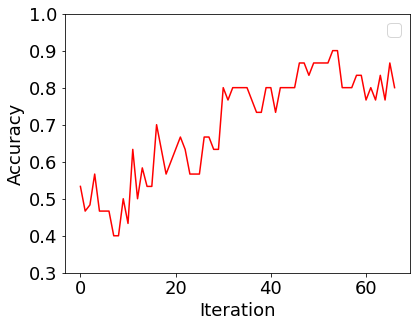

In [10]:
fig = plt.figure(figsize=(8,6))

ax2 = fig.add_axes([.2, .2, .6, .6])
ax2.plot(range(len(test_accs)), test_accs, 'r-')
# ax2.plot(range(len(svm_accs)), svm_accs, 'b-', label='SVM')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0.3, 1)
ax2.legend()

plt.show()